### Edgar Moises Hernandez-Gonzalez
#### 09/04/20-18/04/20
#### Clasificacion de imagenes motoras en EEG con Transfer Learning
##### Con ventaneo y data augmentation
##### Caracteristicas = Espectrogramas STFFT (3D)
##### Concatenacion vertical

##### VGG16
##### Sujeto 1
##### Accuracy = 50.00%
##### Kappa = 0.3333

##### MobileNetV2
##### Sujeto 1
##### Accuracy = 44.10%
##### Kappa = 0.2546

##### NasNetLarge
##### Sujeto 1
##### Accuracy = 47%
##### Kappa = 0.

##### InceptionResNetV2
##### Sujeto 1
##### Accuracy = 45%
##### Kappa = 0.

##### Xception
##### Sujeto 1
##### Accuracy = 46%
##### Kappa = 0.

##### InceptionV3
##### Sujeto 1
##### Accuracy = 50.00%
##### Kappa = 0.3333

##### InceptionV3 + LSTM
##### Sujeto 1
##### Accuracy = 45.83%
##### Kappa = 0.2778

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from scipy.signal import spectrogram
import cv2
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import InceptionV3
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras import backend as K

Using TensorFlow backend.


In [ ]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [ ]:
x_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01T.csv", header=None)
x_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01E.csv", header=None)
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01T.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01E.csv", header=None)

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(288, 22000)
(288, 22000)
(288, 1)
(288, 1)


In [ ]:
n_samples_train = len(y_train)
n_samples_test = len(y_test) #en caso de no tener el y_test se puede utilizar el x_test

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 288
n_samples_test : 288


In [ ]:
n_classes = len(np.unique(y_test)) #esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test

print("n_classes:", n_classes)

n_classes: 4


In [ ]:
# codificar etiquetas con valores de 0 a nClases-1
le = LabelEncoder().fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# las etiquetas en categorical para poder entrenar data augmentation
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

In [ ]:
#unir 22 canales y resize de tamaño proporcional
def unir_espectrogramas_vertical_resize(data):
  dim = (299, 299) #ancho, alto
  fs = 250
  datos = np.zeros((288,299,299,3))
  temporal = np.zeros((528,4,3))
  for i in range(data.shape[0]): #288 muestras
    for j in range(22): #22 canales
      sig = data.iloc[i, j*1000:(j+1)*1000]
      f, t, Sxx = spectrogram(sig, fs) #espectrograma de STFFT
      temporal[j*24:(j+1)*24, :, 0] = Sxx[8:32, :]
      temporal[j*24:(j+1)*24, :, 1] = Sxx[8:32, :]
      temporal[j*24:(j+1)*24, :, 2] = Sxx[8:32, :]
    resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)
    datos[i] = resized
    if i % 100 == 0: #esto solo es para ver como avanza
      print(i)
  return datos

In [ ]:
#llamar a unir_espectrogramas_vertical_resize(data)
x_train = unir_espectrogramas_vertical_resize(x_train)
x_test = unir_espectrogramas_vertical_resize(x_test)

0
100
200
0
100
200


In [ ]:
print(x_train.shape)
print(x_test.shape)

(288, 299, 299, 3)
(288, 299, 299, 3)


In [ ]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

124.52351832617315
88.18918136153654
0.0006962254188471109
0.00013698288039382033
1.171795813706635
1.1849465019572498


In [ ]:
#convertir a float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#escalar los valores en un rango de 0 a 1 (normalizar)
x_train /= 125.0
x_test /= 125.0

In [ ]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

0.99618816
0.7055134
5.5698033e-06
1.095863e-06
0.009374359
0.009479575


In [ ]:
datagen_train = ImageDataGenerator(width_shift_range=0.25)

In [ ]:
base_model = InceptionV3(weights='imagenet',
                   include_top=False,
                   input_shape=x_train.shape[1:])

87916544/87910968 [==============================] - 3s 0us/step


In [ ]:
#base_model.summary()

In [ ]:
#Extraccion de caracteristicas con VGG16
x_train = base_model.predict(x_train)
print(x_train.shape)

x_test = base_model.predict(x_test)
print(x_test.shape)

(288, 8, 8, 2048)
(288, 8, 8, 2048)


#### Esta parte es para RNN

In [ ]:
print(x_train[0,:,:,0].shape)
print(x_train[0,:,:,0])

(8, 8)
[[0.         0.         0.         0.         0.         0.34024605
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.06884426 0.         0.         0.         0.         0.
  0.         0.24952814]
 [0.13019533 0.         0.         0.         0.00522814 0.
  0.4149631  0.00224635]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.01454768 0.         0.         0.         0.         0.
  0.04387344 0.26953173]
 [0.         0.         0.         0.         0.         0.21937244
  0.6971147  0.53967094]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]]


In [ ]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1] * x_train.shape[2], x_train.shape[3]))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1] * x_test.shape[2], x_test.shape[3]))

print(x_train.shape)
print(x_test.shape)

(288, 64, 2048)
(288, 64, 2048)


In [ ]:
print(x_train[0,:,0].shape)
print(x_train[0,:,0])

(64,)
[0.         0.         0.         0.         0.         0.34024605
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.06884426 0.
 0.         0.         0.         0.         0.         0.24952814
 0.13019533 0.         0.         0.         0.00522814 0.
 0.4149631  0.00224635 0.         0.         0.         0.
 0.         0.         0.         0.         0.01454768 0.
 0.         0.         0.         0.         0.04387344 0.26953173
 0.         0.         0.         0.         0.         0.21937244
 0.6971147  0.53967094 0.         0.         0.         0.
 0.         0.         0.         0.        ]


In [ ]:
def transfer_learning_rnn():
  model = Sequential()
  model.add(LSTM(256,
                 dropout=0.5,
                 input_shape=x_train.shape[1:]))
  #model.add(Dropout(0.5))
  model.add(Dense(16, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-5)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model

In [ ]:
def transfer_learning():
  model = Sequential()
  model.add(Flatten(input_shape=x_train.shape[1:]))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
  return model

Iteration: 1


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (288, 8, 8, 2048) (2048 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/100
 - 12s - loss: 1.5329 - accuracy: 0.2674 - val_loss: 1.3499 - val_accuracy: 0.3646
Epoch 2/100
 - 12s - loss: 1.3801 - accuracy: 0.2951 - val_loss: 1.3501 - val_accuracy: 0.3090
Epoch 3/100
 - 12s - loss: 1.3517 - accuracy: 0.3264 - val_loss: 1.3246 - val_accuracy: 0.4236
Epoch 4/100
 - 12s - loss: 1.3310 - accuracy: 0.3368 - val_loss: 1.2896 - val_accuracy: 0.3854
Epoch 5/100
 - 12s - loss: 1.3388 - accuracy: 0.3333 - val_loss: 1.2922 - val_accuracy: 0.3854
Epoch 6/100
 - 12s - loss: 1.3104 - accuracy: 0.3368 - val_loss: 1.2902 - val_accuracy: 0.3681
Epoch 7/100
 - 12s - loss: 1.3037 - accuracy: 0.3924 - val_loss: 1.2951 - val_accuracy: 0.3889
Epoch 8/100
 - 12s - loss: 1.3138 - accuracy: 0.3576 - val_loss: 1.2850 - val_accuracy: 0.4097
Epoch 9/100
 - 12s - loss: 1.3296 - accuracy: 0.3819 - val_loss: 1.2898 - val_accuracy: 0.4410
Epoch 10/100
 - 12s - loss: 1.3172 - accuracy: 0.3507 - val_loss: 1.3083 - val_accuracy: 0.4410
Epoch 11/100
 - 12s - loss: 1.3035 - accuracy: 0.

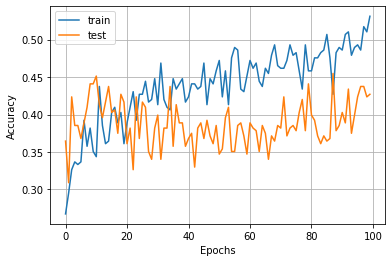

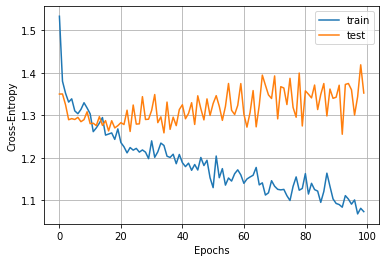


Resultados:
loss: [1.3523290157318115]
accuracy: [0.4270833432674408]
kappa: [0.23611111111111116]


In [ ]:
array_loss = []
array_acc = []
array_kappa = []
for i in range(1):
  print("Iteration:", i+1)
    
  model = transfer_learning()

  history = model.fit_generator(datagen_train.flow(x_train, y_train_categorical, batch_size=18),
                                steps_per_epoch=np.ceil(n_samples_train/18),
                                epochs=100,
                                validation_data=(x_test, y_test_categorical),
                                verbose=2)

  test_loss, test_acc = model.evaluate(x_test, y_test_categorical, verbose=0)
  array_loss.append(test_loss)
  print("loss: ", test_loss)
  array_acc.append(test_acc)
  print("accuracy: ", test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)
    
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
    
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                4194336   
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 132       
Total params: 4,194,468
Trainable params: 4,194,468
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))

Mean Accuracy: 0.4271
std: (+/- 0.0000)
Mean Kappa: 0.2361
std: (+/- 0.0000)
Max Accuracy: 0.4271
Max Kappa: 0.2361
